ThinCurr Python Example: Using HODLR approximation {#doc_tCurr_hodlr}
==========
In this example we demonstrate how to compute eigenvalues/eigenvectors and run a time-domain simulation for a large ThinCurr model using HODLR matrix compression.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
import struct
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pyvista
pyvista.set_jupyter_backend('static') # Comment to enable interactive PyVista plots
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.sensor import Mirnov, save_sensors
from OpenFUSIONToolkit.io import histfile

## Compute eigenvalues

### Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using four threads and a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance that utilizes that execution environment.

Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()".

We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/) below.

In [3]:
myOFT = OFT_env(nthreads=4)
tw_torus = ThinCurr(myOFT)
tw_torus.setup_model(mesh_file='thincurr_ex-ports.h5',xml_filename='oft_in.xml')
tw_torus.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_eddy_modes
Revision id:          28c3ac7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_28728/oftpyin                                                                                                                                      
XML input file        = none                                                                                                                                                                                                    
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =       26500
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =        

### Define Mirnov sensors
To visualize the results we define three Mirnov sensors spanning one port period, just outside the torus. While every sensor in ThinCurr is a flux loop, helper classes for defining specific types of common sensors (eg. circular loop or Mirnovs) are available in \ref OpenFUSIONToolkit.ThinCurr.sensor "OpenFUSIONToolkit.ThinCurr.sensor", which also contains the \ref OpenFUSIONToolkit.ThinCurr.sensor.save_sensors "save_sensors()" function for saving this information to a ThinCurr-compatible file format.

After defining the sensors we use \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.compute_Msensor "compute_Msensor()" to setup the sensors and compute mutual matrices between the sensors and the model (`Msensor`) and the sensors and Icoils (`Msc`).

In [4]:
sensors = []
for i, theta in enumerate(np.linspace(0.0,2.0*np.pi/20.0,3)):
    sensors.append(Mirnov(1.6*np.r_[np.cos(theta),np.sin(theta),0.0], np.r_[0.0,0.0,1.0], 'Bz_{0}'.format(i+1)))
save_sensors(sensors)
Msensor, Msc, sensor_obj = tw_torus.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           3
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix


### Compute inductance and resistivity matrices
With the model setup, we can now compute the self-inductance matrix using HODLR. When HODLR is used the result is a pointer to the Fortran operator, which is stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat_hodlr "tw_torus.Lmat_hodlr". As in any other case, by default, the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** Even though HODLR should significantly accelerate the construction of the self-inductance matrix (see \ref doc_thincurr_ex4 for more information) this process may still take some time to complete.

**Note:** The non-zero savings achieved by HODLR compression is reported after the operator is built. Where in this case only 6% of the original memory is needed resulting in a reduction from > 3 GB to ~ 230 MB (over 10x smaller)!

In [5]:
Mc = tw_torus.compute_Mcoil()

 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix


In [6]:
tw_torus.compute_Lmat(use_hodlr=True,cache_file='HOLDR_L.save')

 Partitioning grid for block low rank compressed operators
   nBlocks =                  32
   Avg block size =          686
   # of SVD =                167
   # of ACA =                161

 Building block low rank inductance operator
   Building hole and Vcoil columns
   Building diagonal blocks
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
   Building off-diagonal blocks using ACA+
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
     Compression ratio:   6.1%  ( 2.94E+07/ 4.82E+08)
     Time =  1m 49s      
   Saving HODLR matrix to file: HOLDR_L.save


In [7]:
tw_torus.compute_Rmat()

 Building resistivity matrix


### Compute eigenvalues/eigenvectors for the plate model
With $\textrm{L}$ and $\textrm{R}$ matrices we can now compute the eigenvalues and eigenvectors of the system $\textrm{L} I = \lambda \textrm{R} I$, where the eigenvalues $\lambda = \tau_{L/R}$ are the decay time-constants of the current distribution corresponding to each eigenvector.

In [8]:
eig_vals, eig_vecs = tw_torus.get_eigs(100,False)

 Starting eigenvalue solve
   Time =    3.1704390000000000     
 Eigenvalues
      3.8803530613713999E-002
      2.3122420111754118E-002
      2.3121318968189739E-002
      2.1444719559314814E-002
      2.0605570653433127E-002


### Save data for plotting
The resulting currents can be saved for plotting using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.save_current "tw_torus.save_current()". Here we save each of the five eigenvectors for visualization. Once all fields have been saved for plotting \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.build_XDMF "tw_torus.build_XDMF()" to generate the [XDMF descriptor files](https://www.xdmf.org/index.php/XDMF_Model_and_Format) for plotting with VisIt of Paraview. This method also returns a \ref OpenFUSIONToolkit.io.XDMF_plot_file "XDMF_plot_file" object, which can be used to read and interact with plot data in Python (see below).

In [9]:
tw_torus.save_current(eig_vecs[0,:],'J_01')
tw_torus.save_current(eig_vecs[1,:],'J_02')
tw_torus.save_current(eig_vecs[2,:],'J_03')
tw_torus.save_current(eig_vecs[3,:],'J_04')
plot_data = tw_torus.build_XDMF()

Removing old Xdmf files
  Removed 23 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: ThinCurr
    Found Mesh: icoils
    Found Mesh: smesh


## Plot current fields using pyvista
Now we plot the current vectors on the plate showing the longest-lived eddy current structure, which corresponds to a large circulation on the plate. The \ref OpenFUSIONToolkit.io.XDMF_plot_file "XDMF_plot_file" class provides functionality to work with the data stored in OFT plot files, including methods to generate information for 3D plotting in Python using [pyvista](https://pyvista.org/).

Plotting data is always associated with a specific mesh, which is itself associated with a physics group. In this case `ThinCurr` is the physics group and the data we are interested in is stored on the surface mesh `smesh`. The `plot_data['ThinCurr']['smesh']` is a \ref OpenFUSIONToolkit.io.XDMF_plot_mesh "XDMF_plot_mesh" object with further functionality for accessing data.

To plot the first eigenvector we first get the pyvista plotting grid using \ref OpenFUSIONToolkit.io.XDMF_plot_mesh.get_pyvista_grid() "get_pyvista_grid()" and then retrieve the vertex-centered field (`J_01_v`) using \ref OpenFUSIONToolkit.io.XDMF_plot_mesh.get_field() "get_field()"

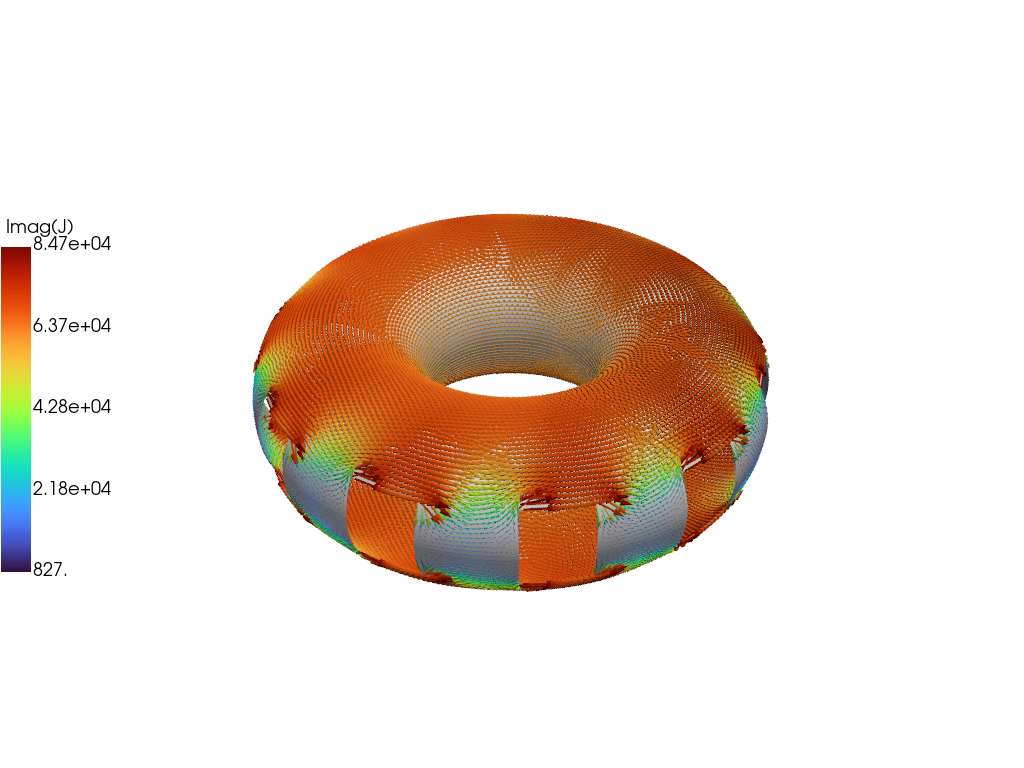

In [10]:
grid = plot_data['ThinCurr']['smesh'].get_pyvista_grid()
J_01 = plot_data['ThinCurr']['smesh'].get_field('J_01_v')

p = pyvista.Plotter()
grid["vectors"] = J_01
grid.set_active_vectors("vectors")
scale = 0.2/(np.linalg.norm(J_01,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "Imag(J)", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.show()

## Run time-domain simulation
With the model fully defined we can now use \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.run_td "run_td()" to perform a time-domain simulation. In this case we simulate 40 ms using a timestep of 0.2 ms (200 steps). We also specify the current in the single I-coil defined in the XML input file as a function of time (`coil_currs`), where the first column specifies time points in ascending order and the remaining columns specify coil currents at each time point.

In [11]:
dt = 2.E-4
nsteps = 200
coil_currs = np.array([
    [0.0, 1.E6],
    [4.E-3, 0.0],
    [1.0, 0.0]
])
tw_torus.run_td(dt,nsteps,status_freq=10,coil_currs=coil_currs,sensor_obj=sensor_obj)


 Starting simulation
 Timestep           10   2.00000009E-03   22.7324562              32
 Timestep           20   4.00000019E-03   44.1192436              18
 Timestep           30   6.00000005E-03   42.2026978              32
 Timestep           40   8.00000038E-03   39.9049339              32
 Timestep           50   9.99999978E-03   37.7692719              32
 Timestep           60   1.20000001E-02   35.7698593              32
 Timestep           70   1.40000004E-02   33.8907852              32
 Timestep           80   1.60000008E-02   32.1206093              32
 Timestep           90   1.79999992E-02   30.4503765              32
 Timestep          100   1.99999996E-02   28.8726788              32
 Timestep          110   2.19999999E-02   27.3811493              32
 Timestep          120   2.40000002E-02   25.9701900              32
 Timestep          130   2.60000005E-02   24.6347961              32
 Timestep          140   2.80000009E-02   23.3704300              32
 Timestep   

### Compute B-field reconstruction operator

In [12]:
_, Bc = tw_torus.compute_Bmat(cache_file='HODLR_B.save')

 Building block low rank magnetic field operator
   Building hole and Vcoil columns
   Building diagonal blocks
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
   Building off-diagonal blocks using ACA+
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
     Compression ratio:   7.1%  ( 1.06E+08/ 1.49E+09)
     Time =  3m 30s      
   Saving HODLR matrix from file: HODLR_B.save


### Generate plot files from run

In [13]:
tw_torus.plot_td(nsteps,compute_B=True,sensor_obj=sensor_obj)
_ = tw_torus.build_XDMF()

 Post-processing simulation
Removing old Xdmf files
  Removed 2 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: ThinCurr
    Found Mesh: icoils
    Found Mesh: smesh


### Load sensor signals from time-domain run

In [14]:
hist_file = histfile('floops.hist')
print(hist_file)


OFT History file: floops.hist
  Number of fields = 4
  Number of entries = 201

  Fields:
    time: Simulation time [s] (d1)
    Bz_1: No description (d1)
    Bz_2: No description (d1)
    Bz_3: No description (d1)

